<a href="https://colab.research.google.com/github/dhaensch/dhaensch.github.io/blob/main/GAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** To create a GAN to generate false images based on CIFAR-10 dataset.  <br><br>
**Description:** This project focused on training a generative adversarial network to generate false images based on the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60,000 color images of size 32×32 pixels, divided into 10 different classes. The GAN's generator and descriminator will be built using convolutional neural networks, and performance will be monitored by graphing the loss functions of the generator and discriminator and through manual inspection of generated images.
 <br> <br>
**Skills:** Deep Learning, Neural Networks, Generative Adversarial Networks, Data Visualization
 <br> <br>
**Technology:** Python, PyTorch, Matplotlib, Numpy
<br> <br>
**Result:** After running the GAN through 15 epochs, there was significant improvement in the quality of the generator's performance. After viewing the real and generated images side by side, the GAN does not appear to have suffered mode collapse and based on the loss graph, the model has not achieved equillibrium yet. Further parameter tuning and more training epochs are recommended for further study.



In [ ]:

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image




Next step is to define the parameters that are going to be used in our model.The main parameters for tuning are the batch size, number of epochs, beta values for optimizers and learning rate. Number of channels, latent vector size, feature mapes and number of GPU are set a variables to allow program to easily update to accomodate other image data sets.

In [ ]:
# Batch size during training
batch_size = 128

# size of training images for transformer
image_size = 64

# 3 channel used for RGB color images
nc = 3

# Size of z latent vector for generator
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Betas for optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

The CIFAR-10 data set is downloaded into dataloader after being resized, centered and cropped, and normalized for use in the GAN. A statement was also added to add compatibility for the program to run on either a CPU or GPU and a folder was created to store the image files and discriminator and generator models we are going to get from our training loss later.

In [ ]:
# Data preparation
transform = transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

#loads the CIFAR-10 dataset
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)

# Decide which if we want to run on GPU or CPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#creates folder to save GAN photos and models
os.makedirs('GAN', exist_ok=True)


100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


This section creates a weight intialization function to reinitialize the weights in the discriminator and generator models to fit a mean of 0 and a standard deviation of 0.2.

In [ ]:
# creates function to initializes weights for discriminator and generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Our generator model function was created to take in a latent vector of size 100 and will consist five convolutional transpose layers with batch normalization and leaky relu activation functions. The output are images of the channel size 3 after going through a tanh activation function. These generated images will be our fake images.

In [ ]:
#defines the generator model class with convolutional neural network
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

The generator model is created and then the weights are initialized using the weights_init function we created above after deciding if it should be run on the CPU or GPU. The generator model is then printed for inspection.

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# randomly initializes generator weights with mean=0 and stdev=0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Our discriminator model function was created to basically be the inverse of the generator model we created earlier. Instead of 5 convolutional transpose layers, we have 5 convolutional layers that go from an input of channel size 3 to an output of 8 times the number of feature maps.Batch normalization and leaky ReLU activation functions are used in the discriminator as well, but the final activation function is a sigmoid activation function rather than tanH. The purpose of this model is to correctly identify images as either real images or generated images.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

The discriminator model is then created and just like the generator, the weights are initialized using the weights_init function we created above after deciding if it should be run on the CPU or GPU. The discriminator model is then printed for inspection.

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# randomly initializes generator weights with mean=0 and stdev=0.02.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


This section defines our loss criteria for our models as binary cross entropy and the optimizers are defined with an adam optimizer. Real and fake label conventions are defined for use in our training loop later and a denormalization function is defined for use in saving our output images during training.

In [ ]:
# Initialize the binary cross entropy loss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


#denormalization function for saving output images
def denorm(x):
    out =(x+1)/2
    return out.clamp(0,1)

Our training loop will go through the number of epochs we set up in the beginning of our script. After initializing blank lists to store our losses for both the generator and discriminator models over the entire training process, we enter a loop to run through each epoch. For each epoch loop, we initialize a list to store the losses for just that epoch and enter a loop to pull images from our dataloader. The Discriminator is trained on both the real and fake image sets and then the generator is trained. The individual losses are saved for both the discriminator and generator as lists and the generated images are saved if the iterations generator loss is less than 0.5. The list of losses for each iteration are then averaged to find the mean losses for each epoch which are printed for review. The list of losses is then added to an overall list of losses for the entirety of training which will allow us to graph the losses over time. At the end of the final epoch, the final real and generated image sets are saved as well as our final discriminator and generator models.

In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # saves losses For each epoch
    epoch_G_losses =[]
    epoch_D_losses =[]

    for i, data in enumerate(dataloader, 0):

        ############################
        #
        # Discriminator training
        #
        ###########################

        #########  Train Discriminator with all-real batch  #################
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #labels the real images 1
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real images through Discriminator
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()


        ###########   Train Discriminator with all-fake batch  ###############
        # Generate noise for generator training
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake images with Generator
        fake = netG(noise)
        label.fill_(fake_label)
        # Train discriminator with generated images
        output = netD(fake.detach()).view(-1)
        # Calculate Discriminator loss on the generated images
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update Discriminator
        optimizerD.step()



        ############################
        #
        # Generator training
        #
        ###########################
        #trains generator twice for every discriminator training
        netG.zero_grad()
        label.fill_(real_label)  # olabels generators as fake images
        # pass generated image batch through discriminator
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for Generator
        errG.backward()
        # Update Generator
        optimizerG.step()


        # Save list of losses for iteration
        epoch_G_losses.append(errG.item())
        epoch_D_losses.append(errD.item())

        #saves fake images if the generator error is less than 0.5 for batch
        if errG.item() < 0.5:
            save_image(denorm(fake), f'./GAN/fake_images_epoch_{epoch+1}_batch_{i}_loss_{errG.item():.4f}.png')


    # Calculate and print mean G loss for the epoch
    mean_G_loss = sum(epoch_G_losses) / len(epoch_G_losses)
    mean_D_loss = sum(epoch_D_losses) / len(epoch_D_losses)

    #added epoch loss list to overall list for graphing
    G_losses.extend(epoch_G_losses)
    D_losses.extend(epoch_D_losses)

    #prints mean generator and discriminator loss every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | Mean D Loss: {mean_D_loss:.4f} | Mean G Loss: {mean_G_loss:.4f}")

    # for the final epoch, save the models and final fake and real image sets
    if (epoch+1) == num_epochs:
        #Saves fake images
        save_image(denorm(fake), f'./GAN/fake_images_final.png')
        #saves the real images
        save_image(denorm(real_cpu), f'./GAN/real_images__final.png')

        #saves the generator model
        torch.save(netG.state_dict(),f'./GAN/CIFAR10_G.ckpt')
        #saves the discriminator model
        torch.save(netD.state_dict(),f'./GAN/CIFAR10_D.ckpt')

Starting Training Loop...
Epoch [1/15] | Mean D Loss: 0.5287 | Mean G Loss: 7.3215
Epoch [2/15] | Mean D Loss: 0.6097 | Mean G Loss: 4.6195
Epoch [3/15] | Mean D Loss: 0.6854 | Mean G Loss: 3.6929
Epoch [4/15] | Mean D Loss: 0.7090 | Mean G Loss: 3.4184
Epoch [5/15] | Mean D Loss: 0.7404 | Mean G Loss: 3.0086
Epoch [6/15] | Mean D Loss: 0.7686 | Mean G Loss: 2.7951
Epoch [7/15] | Mean D Loss: 0.7663 | Mean G Loss: 2.8657
Epoch [8/15] | Mean D Loss: 0.7059 | Mean G Loss: 2.9390
Epoch [9/15] | Mean D Loss: 0.7547 | Mean G Loss: 3.0876
Epoch [10/15] | Mean D Loss: 0.6752 | Mean G Loss: 3.1859
Epoch [11/15] | Mean D Loss: 0.6647 | Mean G Loss: 3.1951
Epoch [12/15] | Mean D Loss: 0.6410 | Mean G Loss: 3.2597
Epoch [13/15] | Mean D Loss: 0.6839 | Mean G Loss: 3.1116
Epoch [14/15] | Mean D Loss: 0.6885 | Mean G Loss: 3.0595
Epoch [15/15] | Mean D Loss: 0.6480 | Mean G Loss: 3.1243


This graph visualizes the discriminator and generator losses over the course of training.

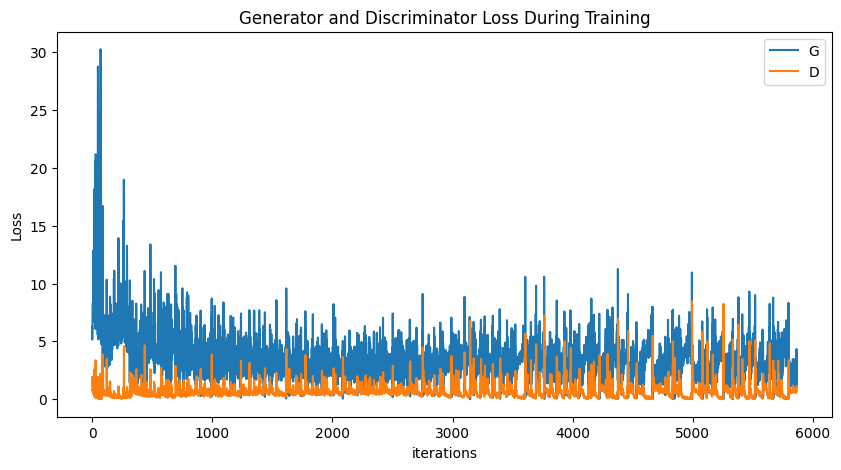

In [ ]:
#plots the generator and discriminator losses during training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


The real images and final generated images are plotted side by side to visualize the differences and inspect the output of the GAN training.

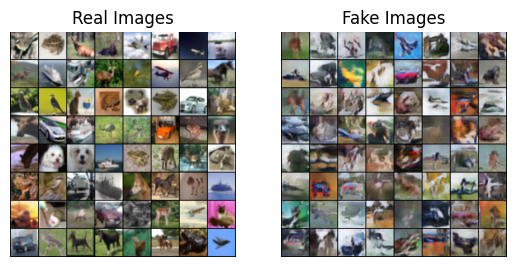

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

####
#Plots real and generated images side by side to show progress
###
# Real Images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Fake Images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake[:64].cpu().detach(), padding=2, normalize=True).numpy(), (1, 2, 0)))

#shows plot
plt.show()